# Chapter 0 — Neural Network Fundamentals

This chapter is a **pre-requisite foundation** for the generative modeling chapters that follow.
We focus on the parts of neural networks you must understand to comfortably read modern papers:
- what a neural network computes
- how losses are defined
- how gradients are computed via **backpropagation**
- how optimization updates parameters
- how to implement these ideas in **PyTorch**

## Learning Objectives
By the end of this chapter, you should be able to:
1. Explain a neural network as a **composition of functions** with parameters
2. Write down common losses (MSE, cross-entropy) and explain what they measure
3. Explain backpropagation as the **chain rule** applied to computational graphs
4. Use PyTorch to inspect gradients and run training loops
5. Train several simple networks (MLP, CNN) including **MNIST**
6. Build a simple **autoencoder**, identify **encoder vs decoder**, and visualize a 2D latent space

## License

**Text, figures, and explanations:**  
© 2026 Imran Zualkernan. Licensed under **CC BY 4.0**.

**Code cells:**  
© 2026 Imran Zualkernan. Licensed under the **MIT License**.

You are free to reuse, modify, and redistribute with attribution.

## 1 A Neural Network is a Differentiable Program

A neural network defines a parametric function:

$$
f_{\theta}(x) \in \mathbb{R}^{k}
$$

where:
- $x$ is the input
- $\theta$ are the parameters (weights and biases)
- $k$ is the output dimension (e.g., number of classes)

Training chooses $\theta$ to minimize a loss:

$$
\theta^{*}
=
\arg\min_{\theta}
\;
\mathbb{E}_{(x,y)\sim\mathcal{D}}
\left[
\mathcal{L}\bigl(f_{\theta}(x), y\bigr)
\right]
$$

### Common building blocks
- Linear layer: $Wx + b$
- Nonlinearity: ReLU, sigmoid, tanh
- Normalization: BatchNorm, LayerNorm
- Loss: MSE, cross-entropy


## 2 Backpropagation in One Sentence

Backpropagation computes gradients of a scalar loss with respect to parameters efficiently by applying the chain rule through a computational graph:

$$
\frac{\partial \mathcal{L}}{\partial \theta}
=
\frac{\partial \mathcal{L}}{\partial a_{L}}
\cdot
\frac{\partial a_{L}}{\partial a_{L-1}}
\cdots
\frac{\partial a_{1}}{\partial \theta}
$$

In PyTorch, this happens when you call:

```python
loss.backward()
```


## 3 Setup

We use:
- `torch`
- `matplotlib`
- `torchvision` (if available) for MNIST, with a fallback to `sklearn` digits so the notebook remains runnable


In [4]:
import os, math, time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


device: cpu


## 4. The Smallest Backprop Example (Inspect Gradients)

We fit a 1D linear model:

$$
\hat{y} = w x + b
$$

with mean squared error (MSE):

$$
\mathcal{L}
=
\frac{1}{N}\sum_{i=1}^{N}\bigl(\hat{y}_{i} - y_{i}\bigr)^{2}
$$

Goal: **see gradients** $\frac{\partial \mathcal{L}}{\partial w}$ and $\frac{\partial \mathcal{L}}{\partial b}$ and perform gradient descent updates.


In [3]:
# Generate Synthetic data: y = 3x + 1 + noise
torch.manual_seed(0)
N = 64
x = torch.linspace(-2, 2, N).unsqueeze(1)
y = 3.0 * x + 1.0 + 0.2 * torch.randn_like(x)

# Parameters we want to learn
# requres_grad=True to track gradients

w = torch.randn(1, 1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Track loss curve
# This will tell us if training is working
# Each entry is the loss at a training step
# We will plot this at the end
loss_history = []

lr = 0.1
# how many steps of gradient descent
# also called iterations or epochs
steps = 60

for step in range(steps):
    # Forward pass: compute predicted y
    y_hat = x @ w + b
    # Compute and print loss (MSE)
    loss = ((y_hat - y) ** 2).mean()

    # Backprop: compute gradients
    # dL/ dw, dL/db 
    # How much does loss change if we change w or b a little bit?
    loss.backward()

    # Store loss for plotting
    loss_history.append(loss.item())

    # Print progress every 10 steps
    if step % 10 == 0 or step == steps - 1:
        print(
            f"step {step:02d} | loss {loss.item():.4f} | "
            f"w {w.item():.3f} | b {b.item():.3f} | "
            f"dw {w.grad.item():.3f} | db {b.grad.item():.3f}"
        )

    # Gradient descent update (manual)
    # use the .no_grad() context to avoid tracking in autograd
    # because we don't want to compute gradients for these operations
    # this is using the learning rule w = w - lr * dL/dw
    # note we are not using the learning rate scheduler here
    # lr is constant and a hyperparameter we set

    with torch.no_grad():
        w -= lr * w.grad
        b -= lr * b.grad

    # IMPORTANT: zero gradients (PyTorch accumulates by default)
    # otherwise gradients would be a sum over all steps
    w.grad.zero_()
    b.grad.zero_()

# Plot loss curve
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.title("Loss curve (MSE vs epochs)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

# Final predictions
# calculate y_pred for all x
with torch.no_grad():
    y_pred = x @ w + b

# Metrics
# Calculate MSE by comparing y_pred to y and taking the mean
mse = ((y_pred - y) ** 2).mean().item()

# R^2 = 1 - SSE/SST
# where SSE = sum of squared errors
#       SST = total sum of squares
#       y_mean = mean of actual y values

y_mean = y.mean()
sse = ((y_pred - y) ** 2).sum()
sst = ((y - y_mean) ** 2).sum()
r2 = (1 - (sse / sst)).item()

# Normalize MSE by variance, mean, range
# unbiased=False for population variance
var_y = y.var(unbiased=False).item()
mean_y = y.mean().item()
range_y = (y.max() - y.min()).item()

mse_over_var = mse / var_y if var_y != 0 else float("inf")
mse_over_mean = mse / abs(mean_y) if mean_y != 0 else float("inf")
mse_over_range = mse / range_y if range_y != 0 else float("inf")

# Print final metrics
# MSE, R^2, MSE/Var(y), MSE/Mean(y), MSE/Range(y)
print("\nFinal metrics:")
print(f"MSE         = {mse:.6f}")
print(f"R^2         = {r2:.6f}")
print(f"MSE/Var(y)  = {mse_over_var:.6f}")
print(f"MSE/Mean(y) = {mse_over_mean:.6f}")
print(f"MSE/Range(y)= {mse_over_range:.6f}")

# Plot actual vs predicted (and y=x reference)
# we use squeeze to remove extra dimensions
# move to cpu and convert to numpy for plotting
x_cpu = x.squeeze().cpu().numpy()
y_cpu = y.squeeze().cpu().numpy()
yp_cpu = y_pred.squeeze().cpu().numpy()

plt.figure(figsize=(6,5))
plt.scatter(y_cpu, yp_cpu, s=25, alpha=0.8)
mn = min(y_cpu.min(), yp_cpu.min())
mx = max(y_cpu.max(), yp_cpu.max())
plt.plot([mn, mx], [mn, mx])
plt.title("Actual vs Predicted (Mini-Lab 1)")
plt.xlabel("Actual y")
plt.ylabel("Predicted y_hat")
plt.grid(True)
plt.show()

# Plot y vs x with fitted line
# this will show how well the line fits the data

plt.figure(figsize=(7,4))
plt.scatter(x_cpu, y_cpu, s=25, alpha=0.8, label="Actual")
order = x_cpu.argsort()
plt.plot(x_cpu[order], yp_cpu[order], label="Predicted")
plt.title("Actual vs Predicted as a function of x")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'torch' is not defined

### What you should notice
- `loss.backward()` populates `.grad` for tensors with `requires_grad=True`
- Gradients **accumulate**, so we must zero them each step
- Optimization is repeated updates using gradients


## 5 Manual Backprop for a 2-Layer Network (By Hand, Then PyTorch)

To see the chain rule explicitly, consider a tiny 2-layer network for a single example:

$$
h = W_{1}x + b_{1}
\quad
a = \mathrm{ReLU}(h)
\quad
\hat{y} = W_{2}a + b_{2}
$$

with scalar MSE loss:

$$
\mathcal{L} = \bigl(\hat{y} - y\bigr)^{2}
$$

We will compute:
- $\frac{\partial \mathcal{L}}{\partial W_{2}}$
- $\frac{\partial \mathcal{L}}{\partial W_{1}}$

and verify with PyTorch autograd.


In [ ]:
torch.manual_seed(0)

# The nueral network has 2 inputs, 1 output
# and 1 hidden layer with 3 units

# Single data points
x = torch.tensor([[2.0, -1.0]])     # shape (1,2)
y = torch.tensor([[1.5]])           # shape (1,1)

# Tiny network sizes: 2 -> 3 -> 1
# Weights and biases are represented as tensors
# We need W1 of shape (3,2), b1 of shape (1,3)
# because hidden layer has 3 units and the input has 2 features
# b1 matches hidden layer shape (1,3)
# Similarly W2 is (1,3) and b2 is (1,1)
# because output layer has 1 unit and hidden layer has 3 units
# b2 matches output shape (1,1)

W1 = torch.randn(3, 2, requires_grad=True)
b1 = torch.randn(1, 3, requires_grad=True)
W2 = torch.randn(1, 3, requires_grad=True)
b2 = torch.randn(1, 1, requires_grad=True)

# Forward

# we need to transform W1 and W2 to match shapes
# x is (1,2), W1.t() is (2,3) -> h is (1,3)
# a is (1,3)
# W2.t() is (3,1) -> y_hat is (1,1)
# use ReLU activation for hidden layer
# loss is sum of squared errors
# between predicted y_hat and actual y

h = x @ W1.t() + b1                 # (1,3)
# We apply ReLU non-linearity to the hidden layer
a = torch.relu(h)                   # (1,3)
#We compute the final output
y_hat = a @ W2.t() + b2             # (1,1)
loss = (y_hat - y).pow(2).sum()

# Autograd
loss.backward()

print("Autograd gradients:")
print("dL/dW2:", W2.grad)
print("dL/dW1:", W1.grad)

# Manual derivatives (outline)
# dL/dy_hat = 2*(y_hat - y)
dL_dyhat = 2 * (y_hat.detach() - y)
# dy_hat/dW2 = a
dL_dW2_manual = dL_dyhat * a.detach()   # broadcasting to (1,3)

# dy_hat/da = W2
dL_da = dL_dyhat @ W2.detach()          # (1,3)
# da/dh = 1[h>0] for ReLU
relu_mask = (h.detach() > 0).float()
dL_dh = dL_da * relu_mask               # (1,3)
# dh/dW1 = x (for each hidden unit)
# W1 has shape (3,2). For unit j: d h_j / d W1[j,:] = x
dL_dW1_manual = dL_dh.t() @ x.detach()  # (3,2)

print("\nManual gradients:")
print("dL/dW2 manual:", dL_dW2_manual)
print("dL/dW1 manual:", dL_dW1_manual)

# Compare max absolute error
err_W2 = (W2.grad - dL_dW2_manual).abs().max().item()
err_W1 = (W1.grad - dL_dW1_manual).abs().max().item()
print("\nMax abs error |W2|:", err_W2, "|W1|:", err_W1)


## 6 Logistic Regression as a 1-Layer Neural Network

Binary classification with logits:
- the model outputs a real number called the **logit** (a score on the real line)
- the sigmoid maps the logit to a probability in $[0,1]$

$$
p(y=1\mid x) = \sigma\bigl(w^{\top}x + b\bigr)
$$

### Two types of points (two classes)
In this example, our dataset contains **two clusters** of points:
- **Class 0** (label $y=0$): points sampled around one center
- **Class 1** (label $y=1$): points sampled around another center

The classifier learns a **decision boundary** that separates these two types of points.

We will visualize the model in **two complementary ways**:
1. A 2D **decision surface** over the input space $(x_1, x_2)$
2. A **marginalized 1D view**: project each point onto the learned direction and plot the logistic curve


## Sigmoid Function — Visualization

The sigmoid function is defined as:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

It maps any real-valued input to the range $(0, 1)$ and is commonly used
to convert **logits** into probabilities in binary classification.


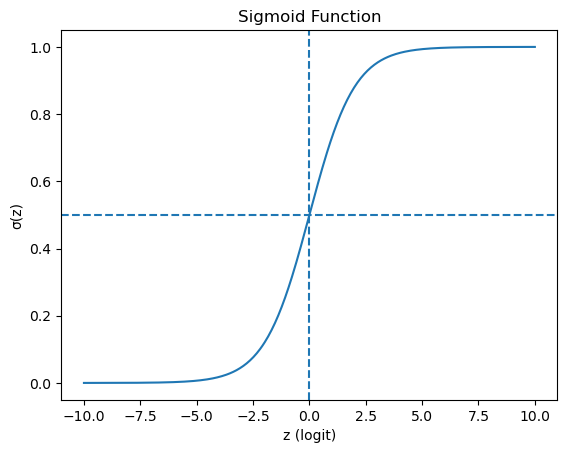

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Generate input range
z = np.linspace(-10, 10, 400)
s = sigmoid(z)

# Plot sigmoid
plt.figure()
plt.plot(z, s)
plt.axhline(0.5, linestyle='--')
plt.axvline(0, linestyle='--')
plt.xlabel("z (logit)")
plt.ylabel("σ(z)")
plt.title("Sigmoid Function")
plt.show()



## Binary Cross-Entropy with Logits — Math Explanation

PyTorch code:

```python
loss = F.binary_cross_entropy_with_logits(logits, y)
```

### 1) Logit and label

Model output (logit): $z \in \mathbb{R}$  
Target label: $y \in \{0,1\}$

### 2) Sigmoid (conceptual)

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

### 3) Binary cross-entropy

For probability $p$:

$$
\mathrm{BCE}(y,p) = -\Big( y\log(p) + (1-y)\log(1-p) \Big)
$$

Substitute $p=\sigma(z)$:

$$
\mathrm{BCE}(y,z) = -\Big( y\log(\sigma(z)) + (1-y)\log(1-\sigma(z)) \Big)
$$

### 4) Logit-only closed form

Using identities:

$$
\log(\sigma(z)) = -\log(1+e^{-z}), \qquad
\log(1-\sigma(z)) = -z - \log(1+e^{-z})
$$

we obtain:

$$
\mathrm{BCE}(y,z) = (1-y)z + \log(1+e^{-z})
$$

### 5) Numerically stable form (used by PyTorch)

$$
\boxed{
\mathrm{BCE}(y,z)=\max(z,0)-zy+\log\!\left(1+e^{-|z|}\right)
}
$$

### 6) Batch loss (default reduction = mean)

For a batch of $N$ samples:

$$
\mathcal{L} = \frac{1}{N}\sum_{i=1}^{N}
\left[\max(z_i,0)-z_i y_i+\log\!\left(1+e^{-|z_i|}\right)\right]
$$

### 7) Gradient (what backprop sees)

$$
\boxed{\frac{\partial \mathcal{L}}{\partial z} = \sigma(z) - y}
$$

### 8) Why “with logits”?

Doing `sigmoid` and `BCE` separately can be numerically unstable for large $|z|$.  
`binary_cross_entropy_with_logits` combines them into the stable form above.



torch.Size([800, 2])
torch.Size([800, 1])
epoch 00 | loss 0.3167
epoch 01 | loss 0.0946
epoch 02 | loss 0.0599
epoch 03 | loss 0.0449
epoch 04 | loss 0.0363
epoch 05 | loss 0.0307
epoch 06 | loss 0.0268
epoch 07 | loss 0.0238
epoch 08 | loss 0.0215
epoch 09 | loss 0.0196


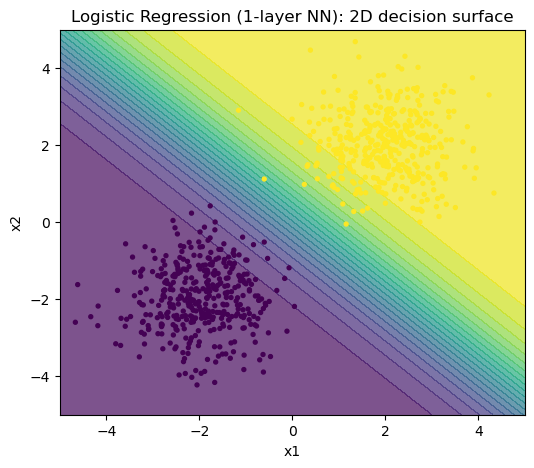

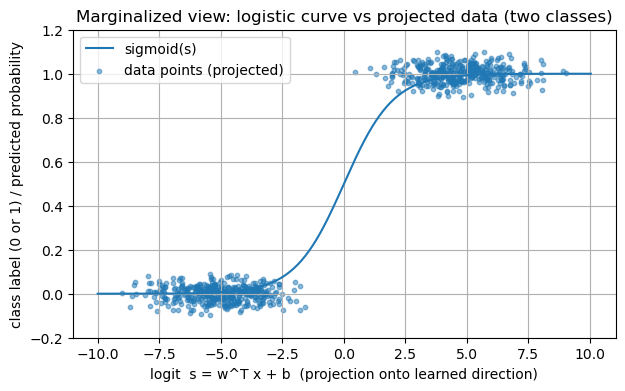

In [5]:
torch.manual_seed(1)
n = 800

# Two clusters => two classes
# Class 0 around (-2, -2), class 1 around (+2, +2)
x0 = torch.randn(n//2, 2) * 0.8 + torch.tensor([-2.0, -2.0])
x1 = torch.randn(n//2, 2) * 0.8 + torch.tensor([ 2.0,  2.0])

# cat allows us to concatenate tensors along a given dimension
# samples from x0 come first
# samples from x1 come after

X = torch.cat([x0, x1], dim=0)

print(X.shape)

# unsqueeze(1) to make Y shape (n,1)
Y = torch.cat([torch.zeros(n//2), torch.ones(n//2)]).unsqueeze(1)
print(Y.shape)

# Create DataLoader for batching
ds = TensorDataset(X, Y)
dl = DataLoader(ds, batch_size=64, shuffle=True)

# Create model: single linear layer (logistic regression)
# .todevice to move model parameters to GPU if available

model = nn.Linear(2, 1).to(device)

# Optimizer for updating model parameters
opt = torch.optim.SGD(model.parameters(), lr=0.1)

# Train loop for 10 epochs
for epoch in range(10):
    total = 0.0
    # xb, yb are batches of data picked from DataLoader
    for xb, yb in dl:
        # Move batch to device
        xb, yb = xb.to(device), yb.to(device)

        # calculate logits or pre-sigmoid outputs
        logits = model(xb)  # shape (B,1)

        # calculate binary cross-entropy loss with logits
        loss = F.binary_cross_entropy_with_logits(logits, yb)

        # Backprop and update parameters
        # zero gradients, compute gradients, take optimizer step
        opt.zero_grad()
        loss.backward()
        opt.step()
        # accumulate loss for reporting
        # xb.size(0) is the batch size
        total += loss.item() * xb.size(0)
    print(f"epoch {epoch:02d} | loss {total/len(ds):.4f}")

# -----------------------------
# View 1: 2D decision surface
# -----------------------------
with torch.no_grad():
    xx, yy = torch.meshgrid(torch.linspace(-5,5,200), torch.linspace(-5,5,200), indexing="ij")
    grid = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1).to(device)
    probs = torch.sigmoid(model(grid)).reshape(200,200).cpu()

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, probs, levels=20, alpha=0.7)
plt.scatter(X[:,0], X[:,1], c=Y.squeeze(), s=8)
plt.title("Logistic Regression (1-layer NN): 2D decision surface")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

# ---------------------------------------------------------
# View 2 (marginalized): 1D logistic curve + projected points
# ---------------------------------------------------------
# Logistic regression depends on x only through the scalar logit s = w^T x + b.
# So we can "marginalize" the 2D input by projecting each point onto this learned direction.
with torch.no_grad():
    w = model.weight.detach().cpu().view(-1)     # shape (2,)
    b = model.bias.detach().cpu().item()
    X_cpu = X.cpu()
    Y_cpu = Y.cpu().squeeze()

    # scalar logits for each datapoint
    s = (X_cpu @ w) + b                          # shape (N,)

    # create a smooth logistic curve over s
    s_grid = torch.linspace(s.min()-1, s.max()+1, 400)
    p_grid = torch.sigmoid(s_grid)

# Plot the curve and the labeled points
plt.figure(figsize=(7,4))

# logistic curve
plt.plot(s_grid.numpy(), p_grid.numpy(), label="sigmoid(s)")

# points: show as y=0 or y=1 with small vertical jitter so you can see density
jitter = 0.04 * torch.randn_like(Y_cpu.float())
plt.scatter(s.numpy(), (Y_cpu.float() + jitter).numpy(), s=10, alpha=0.5, label="data points (projected)")

plt.ylim(-0.2, 1.2)
plt.title("Marginalized view: logistic curve vs projected data (two classes)")
plt.xlabel("logit  s = w^T x + b  (projection onto learned direction)")
plt.ylabel("class label (0 or 1) / predicted probability")
plt.grid(True)
plt.legend()
plt.show()


## 7 A 2-Layer MLP for XOR

XOR is not linearly separable, so we need a nonlinearity and at least one hidden layer.


## Hyperbolic Tangent (tanh) — Visualization

The hyperbolic tangent function is defined as:

$$
\tanh(z) = \frac{e^{z} - e^{-z}}{e^{z} + e^{-z}}
$$

It maps any real-valued input to the range $(-1, 1)$ and is commonly used as an activation function in neural networks.

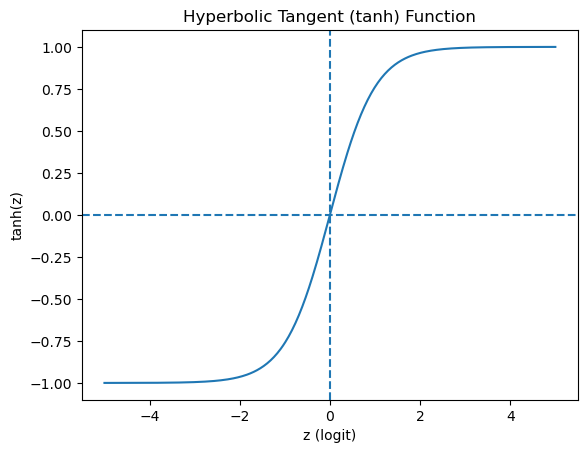

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Define tanh function
def tanh(z):
    return np.tanh(z)

# Generate input range
z = np.linspace(-5, 5, 400)
t = tanh(z)

# Plot tanh
plt.figure()
plt.plot(z, t)
plt.axhline(0, linestyle='--')
plt.axvline(0, linestyle='--')
plt.xlabel("z (logit)")
plt.ylabel("tanh(z)")
plt.title("Hyperbolic Tangent (tanh) Function")
plt.show()

In [20]:
# create data for XOR
X = torch.tensor([[0.,0.],[0.,1.],[1.,0.],[1.,1.]])
Y = torch.tensor([[0.],[1.],[1.],[0.]])

# create a model with one hidden layer
# 2 inputs, 8 hidden units, 1 output

mlp = nn.Sequential(
    nn.Linear(2, 8),
# internal non-linearity does not have to be sigmoid 
# the domain of tanh is all real numbers,
# and its range is (-1, 1), which works well here
    nn.Tanh(),
    nn.Linear(8, 1)
).to(device)

# Optimizer for updating model parameters
opt = torch.optim.Adam(mlp.parameters(), lr=0.05)

for step in range(2000):
    # xb and yb are the full dataset here
    xb, yb = X.to(device), Y.to(device)
    #calculate logits or pre-sigmoid outputs
    logits = mlp(xb)
    
    # calculate binary cross-entropy loss with logits 
    # sigmoid is applied inside the loss function

    loss = F.binary_cross_entropy_with_logits(logits, yb)

    # Backprop and update parameters
    opt.zero_grad()
    loss.backward()
    # step the optimizer to update parameters
    opt.step()

with torch.no_grad():
    # >0.5 to convert probabilities to class predictions
    preds = (torch.sigmoid(mlp(X.to(device))) > 0.5).float().cpu()
print("XOR predictions (x1, x2, pred):")
print(torch.cat([X, preds], dim=1))


XOR predictions (x1, x2, pred):
tensor([[0., 0., 0.],
        [0., 1., 1.],
        [1., 0., 1.],
        [1., 1., 0.]])


## 0.8 MNIST with a Simple MLP

We train a basic classifier on MNIST:
- flatten the image
- two-layer MLP
- cross-entropy loss

If MNIST cannot be downloaded, we fall back to `sklearn.datasets.load_digits()` (8×8 digits).


In [ ]:
# load MNIST dataset with fallback to sklearn digits

def get_digits_loaders(batch_size=128):
    try:
        from torchvision import datasets, transforms
        tfm = transforms.Compose([transforms.ToTensor()])
        train = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
        test  = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)

        # create DataLoaders for batching for MNIST dataset
        train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=0)
        test_loader  = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=0)

        # define dataset properties
        input_shape = (1, 28, 28)
        num_classes = 10
        dataset_name = "MNIST (torchvision)"
        return train_loader, test_loader, input_shape, num_classes, dataset_name
    except Exception as e:
        print("MNIST download/load failed; using sklearn digits fallback")
        print("Reason:", repr(e))
        from sklearn.datasets import load_digits
        data = load_digits()
        X = torch.tensor(data.images, dtype=torch.float32).unsqueeze(1) / 16.0
        y = torch.tensor(data.target, dtype=torch.long)
        n = X.size(0)
        idx = torch.randperm(n)
        n_train = int(0.8 * n)
        train_idx, test_idx = idx[:n_train], idx[n_train:]
        train_ds = TensorDataset(X[train_idx], y[train_idx])
        test_ds  = TensorDataset(X[test_idx], y[test_idx])
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
        input_shape = (1, 8, 8)
        num_classes = 10
        dataset_name = "sklearn digits (fallback)"
        return train_loader, test_loader, input_shape, num_classes, dataset_name

train_loader, test_loader, input_shape, num_classes, dataset_name = get_digits_loaders()
print("Using:", dataset_name, "| input_shape:", input_shape)


Using: MNIST (torchvision) | input_shape: (1, 28, 28)


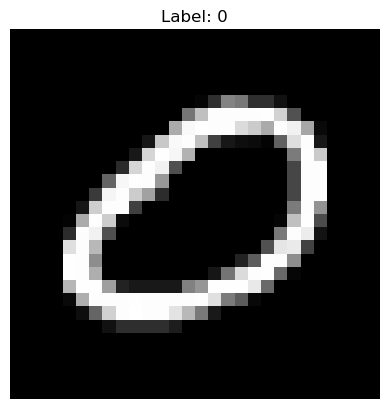

In [24]:
import random
import matplotlib.pyplot as plt

# Get one batch from the DataLoader
images, labels = next(iter(train_loader))

# Pick a random index from the batch
idx = random.randint(0, images.size(0) - 1)

# Extract image and label
img = images[idx].squeeze()   # remove channel dim
label = labels[idx].item()

# Display
plt.figure()
plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

In [22]:
# Define MLP model
# inherit from nn.Module

class MLPClassifier(nn.Module):
    def __init__(self, input_shape, num_classes=10):
        super().__init__()
        # c = channels, h = height, w = width
        c, h, w = input_shape
        # compute flattened input dimension into d
        d = c * h * w
        
        # using self to define layers 
        # .net method is in nn.Module
        # children modules registered this way

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    # define forward pass
    def forward(self, x):
        return self.net(x)

def accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        # xb, yb are batches from DataLoader
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            # we are using argmax to get predicted class
            # by selecting the class with highest logit
            pred = model(xb).argmax(dim=1)
            correct += (pred == yb).sum().item()
            # numel() gives number of elements in yb
            # recording how many samples we processed
            total += yb.numel()
    # we are calling this function here to set model back to train mode
    # .train() sets the model to training mode
    # this is needed if model has layers like dropout or batchnorm
    # model.train()
    return correct / total

# input shape and num_classes defined earlier
mlp = MLPClassifier(input_shape, num_classes).to(device)
opt = torch.optim.Adam(mlp.parameters(), lr=1e-3)

for epoch in range(5):
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        loss = F.cross_entropy(mlp(xb), yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
    print(f"epoch {epoch+1} | test acc: {accuracy(mlp, test_loader):.4f}")


epoch 1 | test acc: 0.9470
epoch 2 | test acc: 0.9685
epoch 3 | test acc: 0.9747
epoch 4 | test acc: 0.9740
epoch 5 | test acc: 0.9748


## 9 MNIST with a Simple CNN

A CNN exploits spatial structure via local receptive fields and weight sharing.


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, input_shape, num_classes=10):
        super().__init__()
        c, h, w = input_shape
        self.conv = nn.Sequential(
            # 2d convolutional layers with ReLU and MaxPool
            # 16 filters and 3 x 3 kernels with c input channels
            nn.Conv2d(c, 16, 3, padding=1), nn.ReLU(),

            # MaxPool to reduce spatial dimensions
            # because of pooling, h and w reduced by factor of 4
            nn.MaxPool2d(2),

            # second conv layer: 32 filters, 3 x 3 kernels

            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),

            # another MaxPool to reduce spatial dimensions
            # to h/4 and w/4
            nn.MaxPool2d(2),
        )
        with torch.no_grad():
            # adds the batch dimension. x = torch.zeros(1, 1, 28, 28)
            # because the input is (1, 28, 28) for MNIST

            x = torch.zeros(1, *input_shape)
            
            # compute flattened feature size after conv layers
            # We needs this as input to the fully connected layers
            # .view(1, -1) flattens everything, including the batch dimension
            # .size(1)gives the total number of elements

            f = self.conv(x).view(1, -1).size(1)
        
        # fully connected layers with one hidden layer
        # the classification head

        self.fc = nn.Sequential(
            nn.Linear(f, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        #x = x.view(x.size(0), -1)
        return self.fc(x)

cnn = SimpleCNN(input_shape, num_classes).to(device)
opt = torch.optim.Adam(cnn.parameters(), lr=1e-3)

for epoch in range(5):
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        loss = F.cross_entropy(cnn(xb), yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
    print(f"epoch {epoch+1} | test acc: {accuracy(cnn, test_loader):.4f}")


epoch 1 | test acc: 0.9739
epoch 2 | test acc: 0.9824
epoch 3 | test acc: 0.9847
epoch 4 | test acc: 0.9875
epoch 5 | test acc: 0.9876


# Cross-Entropy Loss in PyTorch — with Softmax Plot and Loss Curves

We want to understand what this line means:

```python
loss = F.cross_entropy(cnn(xb), yb)
```

`F.cross_entropy(logits, labels)` is the standard loss for **multi-class classification**. It combines:
- **softmax** (to turn logits into probabilities), and
- **negative log-likelihood** (to penalize low probability on the correct class)

in a single numerically-stable operation.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

print("torch:", torch.__version__)
# Generate synthetic data for binary classification

torch: 2.5.1



## The math (logits → softmax → cross-entropy)

### Logits
A CNN outputs logits:

$$
z = cnn(xb) \in \mathbb{R}^{N \times C}
$$

- $N$ = batch size
- $C$ = number of classes
- $z_{i,c}$ = score (logit) for class $c$ of sample $i$

### Labels
Targets are integer class indices:

$$
y \in \{0,1,\dots,C-1\}^N
$$

### Softmax
Softmax converts logits to probabilities:

$$
p_{i,c} = \frac{e^{z_{i,c}}}{\sum_{k=1}^{C} e^{z_{i,k}}}
$$

### Cross-entropy for one sample
If the correct class is $y_i$, the loss is defined as -log because if the probability is 1 then the loss is maximized and vice-versa:

$$
\mathcal{L}_i = -\log\big(p_{i,y_i}\big)
$$

### Combined logit form (what PyTorch computes)
`F.cross_entropy` uses a stable form (softmax + log combined):

$$
\mathcal{L}_i = - z_{i,y_i} + \log\left(\sum_{k=1}^{C} e^{z_{i,k}}\right)
$$

### Batch loss (default: mean)
$$
\mathcal{L} = \frac{1}{N}\sum_{i=1}^{N}\mathcal{L}_i
$$


## 10 Autoencoder: Encoder, Decoder, and Latent Space Visualization

An autoencoder learns to reconstruct its input:

- Encoder $f_{\phi}(x)$ maps $x \to z$
- Decoder $g_{\theta}(z)$ maps $z \to \hat{x}$

$$
z = f_{\phi}(x)
\quad
\hat{x} = g_{\theta}(z)
$$

A common loss is MSE reconstruction:

$$
\mathcal{L}_{\mathrm{recon}} = \lVert x - \hat{x} \rVert_{2}^{2}
$$

To visualize the latent space directly, we set $z \in \mathbb{R}^{2}$.


In [26]:

class Autoencoder2D(nn.Module):
    def __init__(self, input_shape, zdim=2):
        super().__init__()
        c, h, w = input_shape
        d = c * h * w
        
        # input dimension is d
        # define encoder which maps input to latent space
        # latent dimension is zdim

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d, 256), nn.ReLU(),
            nn.Linear(256, 64), nn.ReLU(),
            nn.Linear(64, zdim)
        )

        # define decoder which maps latent space back to input space
        # output dimension is d

        self.decoder = nn.Sequential(
            nn.Linear(zdim, 64), nn.ReLU(),
            nn.Linear(64, 256), nn.ReLU(),
            nn.Linear(256, d),
            nn.Sigmoid()
        )
        self.input_shape = input_shape

    def forward(self, x):
        z = self.encoder(x)
        xhat = self.decoder(z).view(x.size(0), *self.input_shape)
        return xhat, z

ae = Autoencoder2D(input_shape, zdim=2).to(device)
opt = torch.optim.Adam(ae.parameters(), lr=1e-3)

for epoch in range(8):
    total = 0.0
    for xb, _ in train_loader:
        xb = xb.to(device)
        xhat, _ = ae(xb)
        loss = F.mse_loss(xhat, xb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item() * xb.size(0)
    print(f"epoch {epoch+1} | recon mse: {total/len(train_loader.dataset):.5f}")


epoch 1 | recon mse: 0.06297
epoch 2 | recon mse: 0.04945
epoch 3 | recon mse: 0.04597
epoch 4 | recon mse: 0.04396
epoch 5 | recon mse: 0.04270
epoch 6 | recon mse: 0.04183
epoch 7 | recon mse: 0.04114
epoch 8 | recon mse: 0.04057


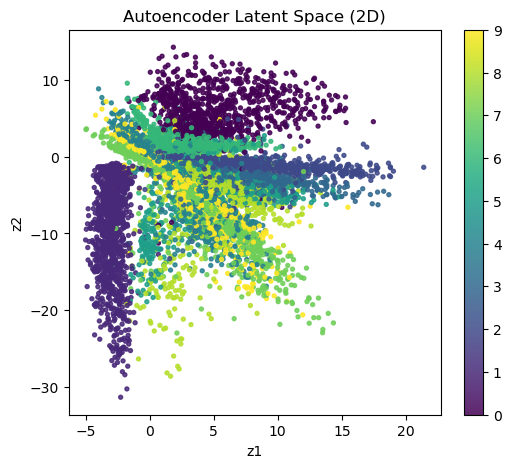

In [ ]:
# Latent visualization on test set
# .eval() sets the model to evaluation mode
ae.eval()

# we use Zs and Ys lists to collect latent vectors and labels
Zs, Ys = [], []

with torch.no_grad():
    # xb, yb are batches from test_loader
    for xb, yb in test_loader:
        xb = xb.to(device)
        # returns the latent vector z
        _, z = ae(xb)
        # collect latent vectors and labels
        Zs.append(z.cpu())
        Ys.append(yb)

# use need to concatenate all batches
# dim=0 to concatenate along the batch dimension

Z = torch.cat(Zs, dim=0).numpy()
Y = torch.cat(Ys, dim=0).numpy()

plt.figure(figsize=(6,5))
plt.scatter(Z[:,0], Z[:,1], c=Y, s=8, alpha=0.85)
plt.title("Autoencoder Latent Space (2D)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.colorbar()
plt.show()


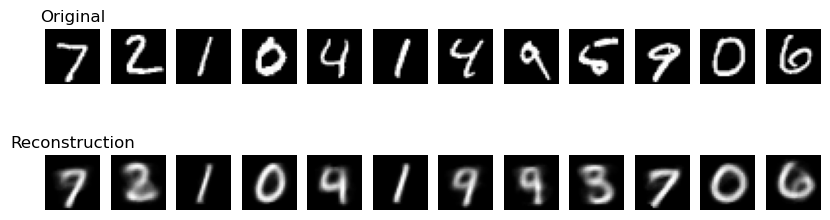

In [29]:
# Reconstructions
ae.train()
xb, _ = next(iter(test_loader))
xb = xb.to(device)[:12]
with torch.no_grad():
    # get the reconstructed images
    xhat, _ = ae(xb)

xb = xb.cpu()
xhat = xhat.cpu()

plt.figure(figsize=(10,3))
for i in range(12):
    plt.subplot(2, 12, i+1)
    plt.imshow(xb[i,0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Original")

    plt.subplot(2, 12, 12+i+1)
    plt.imshow(xhat[i,0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Reconstruction")
plt.show()


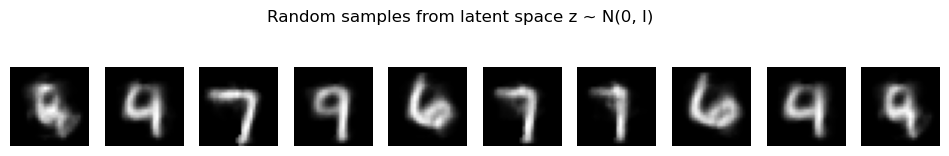

In [30]:
import torch
import matplotlib.pyplot as plt

ae.eval()

# Number of samples to generate
n = 10
zdim = 2

with torch.no_grad():
    # Sample random latent vectors z ~ N(0, I)
    z = torch.randn(n, zdim).to(device)

    # Decode
    x_gen = ae.decoder(z)

    # Reshape to image format
    x_gen = x_gen.view(n, *ae.input_shape).cpu()

# Plot
plt.figure(figsize=(12, 2))
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(x_gen[i].squeeze(), cmap="gray")
    plt.axis("off")

plt.suptitle("Random samples from latent space z ~ N(0, I)")
plt.show()


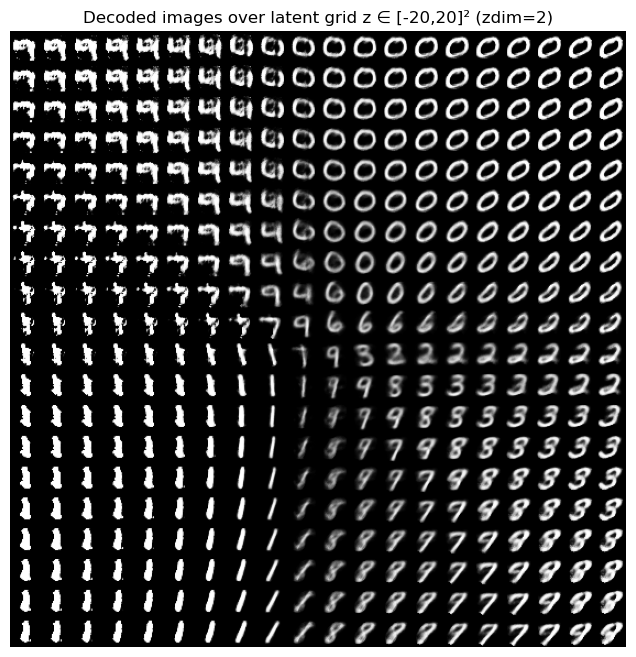

In [35]:
import torch
import matplotlib.pyplot as plt
import numpy as np

ae.eval()

# Grid settings
grid_n = 20          # 20x20 grid (increase for higher resolution)
z_min, z_max = -20, 20 # latent range to visualize

# Create grid of (z1, z2)
z1 = np.linspace(z_min, z_max, grid_n)
z2 = np.linspace(z_min, z_max, grid_n)

with torch.no_grad():
    # Prepare a big canvas to place generated images
    c, h, w = ae.input_shape
    canvas = np.zeros((grid_n * h, grid_n * w), dtype=np.float32)

    for i, a in enumerate(z2[::-1]):     # reverse so higher z2 appears at top
        for j, b in enumerate(z1):
            z = torch.tensor([[b, a]], dtype=torch.float32, device=device)  # shape (1,2)
            x = ae.decoder(z).view(1, c, h, w).cpu().numpy()[0, 0]          # take channel 0
            canvas[i*h:(i+1)*h, j*w:(j+1)*w] = x

plt.figure(figsize=(8, 8))
plt.imshow(canvas, cmap="gray")
plt.axis("off")
plt.title(f"Decoded images over latent grid z ∈ [{z_min},{z_max}]² (zdim=2)")
plt.show()


## Exercises

### Exercise 1 — Backprop sanity checks
- In the first example, change the true slope from $3$ to $-2.5$ and observe how $w$ converges
- Explain why gradients flip sign

### Exercise 2 — Overfitting vs generalization
- In the digits MLP, increase hidden sizes (e.g., 1024) and train longer
- Track train vs test accuracy and identify overfitting

### Exercise 3 — CNN inductive bias
- Compare MLP vs CNN accuracy after the same number of epochs
- Explain why CNN typically performs better on images

### Exercise 4 — Latent space reasoning
- Change latent dimension from $2$ to $8$ (skip plotting)
- Explain what you lose and gain by leaving 2D


## 11 Solutions (Explanations + Code)

This section provides **worked solutions** to the exercises above. Try the exercises first, then compare your reasoning and results here.


### Solution 1 — Backprop sanity checks (changing the slope)

If we change the true slope from $3$ to $-2.5$, the optimal parameter becomes $w^{*}\approx -2.5$.
The sign of the gradient flips because the gradient of MSE contains the residual $(\hat{y}-y)$:

$$
\frac{\partial}{\partial w}\;\frac{1}{N}\sum_{i=1}^{N}(wx_{i} + b - y_{i})^{2}
=
\frac{2}{N}\sum_{i=1}^{N}(wx_{i} + b - y_{i})\,x_{i}
$$

If $y$ decreases when $x$ increases (negative slope), then many residuals push the update direction so that $w$ becomes negative.


Learned w ~ -2.469588041305542  | learned b ~ 1.0185370445251465


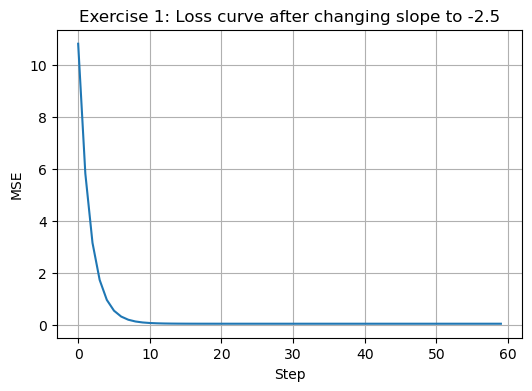

In [36]:
# Solution 1 code: change slope to -2.5 and observe convergence + loss curve

torch.manual_seed(0)
N = 64
x = torch.linspace(-2, 2, N).unsqueeze(1)
y = (-2.5) * x + 1.0 + 0.2 * torch.randn_like(x)

w = torch.randn(1, 1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

lr = 0.1
steps = 60
loss_hist = []

for step in range(steps):
    y_hat = x @ w + b
    loss = ((y_hat - y) ** 2).mean()
    loss.backward()
    loss_hist.append(loss.item())

    with torch.no_grad():
        w -= lr * w.grad
        b -= lr * b.grad
    w.grad.zero_()
    b.grad.zero_()

print("Learned w ~", float(w.detach()), " | learned b ~", float(b.detach()))

plt.figure(figsize=(6,4))
plt.plot(loss_hist)
plt.title("Exercise 1: Loss curve after changing slope to -2.5")
plt.xlabel("Step")
plt.ylabel("MSE")
plt.grid(True)
plt.show()


### Solution 2 — Overfitting vs generalization

Overfitting happens when the model has enough capacity to **memorize** training data (including noise).
A common symptom is:

- training accuracy keeps increasing
- test accuracy plateaus or decreases

Below, we make the MLP much larger and train longer while tracking **train vs test accuracy**.


In [38]:
# Solution 2 code: bigger MLP, longer training, track train vs test accuracy

def accuracy_on_loader(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.numel()
    model.train()
    return correct / total

class BigMLP(nn.Module):
    def __init__(self, input_shape, num_classes=10, hidden=1024):
        super().__init__()
        c, h, w = input_shape
        d = c * h * w
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        return self.net(x)

big_mlp = BigMLP(input_shape, num_classes, hidden=1024).to(device)
opt = torch.optim.Adam(big_mlp.parameters(), lr=1e-3)

train_acc_hist, test_acc_hist = [], []
epochs = 25

for epoch in range(epochs):
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        loss = F.cross_entropy(big_mlp(xb), yb)
        opt.zero_grad()
        loss.backward()
        opt.step()

    tr_acc = accuracy_on_loader(big_mlp, train_loader)
    te_acc = accuracy_on_loader(big_mlp, test_loader)
    train_acc_hist.append(tr_acc)
    test_acc_hist.append(te_acc)
    print(f"epoch {epoch+1:02d} | train acc {tr_acc:.4f} | test acc {te_acc:.4f}")

plt.figure(figsize=(7,4))
plt.plot(train_acc_hist, label="train acc")
plt.plot(test_acc_hist, label="test acc")
plt.title("Exercise 2: Overfitting (train vs test accuracy)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


KeyboardInterrupt: 

### Solution 3 — CNN inductive bias (MLP vs CNN)

CNNs typically perform better on images because they encode inductive biases:
- **locality** (nearby pixels are related)
- **weight sharing** (fewer parameters)
- **translation robustness** (via pooling / shared filters)

Below we train a small MLP and CNN for the same number of epochs and compare test accuracy.


In [39]:
# Solution 3 code: train a small MLP and CNN for the same epochs and compare accuracy

# Small MLP
mlp_small = MLPClassifier(input_shape, num_classes).to(device)
opt_mlp = torch.optim.Adam(mlp_small.parameters(), lr=1e-3)

# CNN
cnn_small = SimpleCNN(input_shape, num_classes).to(device)
opt_cnn = torch.optim.Adam(cnn_small.parameters(), lr=1e-3)

epochs = 5
for epoch in range(epochs):
    # MLP epoch
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        loss = F.cross_entropy(mlp_small(xb), yb)
        opt_mlp.zero_grad()
        loss.backward()
        opt_mlp.step()

    # CNN epoch
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        loss = F.cross_entropy(cnn_small(xb), yb)
        opt_cnn.zero_grad()
        loss.backward()
        opt_cnn.step()

    mlp_acc = accuracy(mlp_small, test_loader)
    cnn_acc = accuracy(cnn_small, test_loader)
    print(f"epoch {epoch+1} | MLP test acc {mlp_acc:.4f} | CNN test acc {cnn_acc:.4f}")


epoch 1 | MLP test acc 0.9508 | CNN test acc 0.9729
epoch 2 | MLP test acc 0.9658 | CNN test acc 0.9816
epoch 3 | MLP test acc 0.9705 | CNN test acc 0.9858
epoch 4 | MLP test acc 0.9770 | CNN test acc 0.9869
epoch 5 | MLP test acc 0.9762 | CNN test acc 0.9902


### Solution 4 — Latent dimension: $2$ vs $8$

A 2D latent space is great for visualization, but it can bottleneck reconstruction.
Increasing latent dimension (e.g., to 8) usually:
- reduces reconstruction error (lower MSE)
- produces a latent representation that is harder to visualize directly

Below we train an 8D autoencoder and show reconstructions.


In [ ]:
# Solution 4 code: train an 8D autoencoder and compare reconstruction error

ae8 = Autoencoder2D(input_shape, zdim=8).to(device)
opt = torch.optim.Adam(ae8.parameters(), lr=1e-3)

epochs = 8
for epoch in range(epochs):
    total = 0.0
    for xb, _ in train_loader:
        xb = xb.to(device)
        xhat, _ = ae8(xb)
        loss = F.mse_loss(xhat, xb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item() * xb.size(0)
    print(f"epoch {epoch+1} | recon mse: {total/len(train_loader.dataset):.6f}")

# Show reconstructions
xb, _ = next(iter(test_loader))
xb = xb.to(device)[:12]
with torch.no_grad():
    xhat, _ = ae8(xb)

xb = xb.cpu()
xhat = xhat.cpu()

plt.figure(figsize=(10,3))
for i in range(12):
    plt.subplot(2, 12, i+1)
    plt.imshow(xb[i,0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Original")

    plt.subplot(2, 12, 12+i+1)
    plt.imshow(xhat[i,0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Recon (z=8)")
plt.show()


## Use of Generative AI

Portions of this material were developed with the assistance of **generative artificial intelligence tools.  
The author reviewed, edited, and validated all content, including explanations, code, and examples, and assumes full responsibility for accuracy and interpretation.